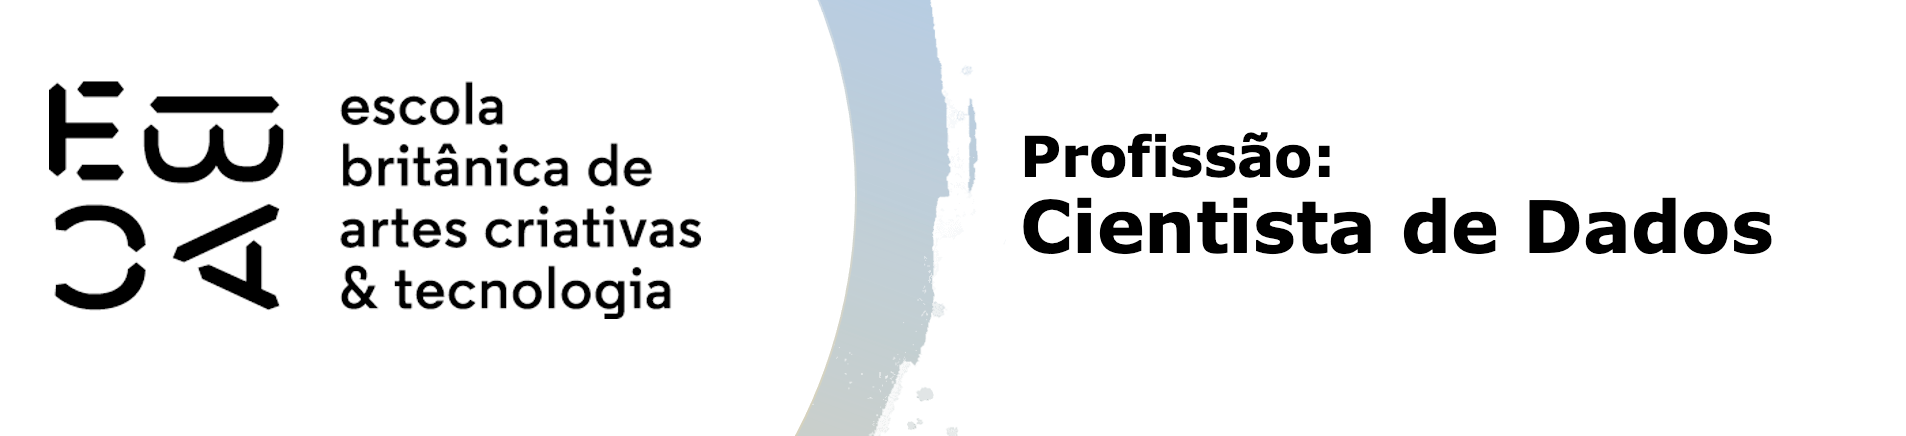

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import t
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve
from pycaret.classification import *
import warnings
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [3]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=8)
    
    ax[1] = biv.cont.plot.bar()
    return biv

In [4]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

In [5]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [6]:
' + '.join(list(df.columns))

'data_ref + index + sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau'

In [7]:
df.set_index('data_ref', inplace = True)

df_train = df['2015-01-01':'2015-12-01']
df_test = df['2016-01-01':]

In [8]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [9]:
df_train['Mes'] = df_train['data_ref'].dt.month
warnings.filterwarnings('ignore')

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

Text(0.5, 1.0, 'Número de linhas para cada mês da base de treino')

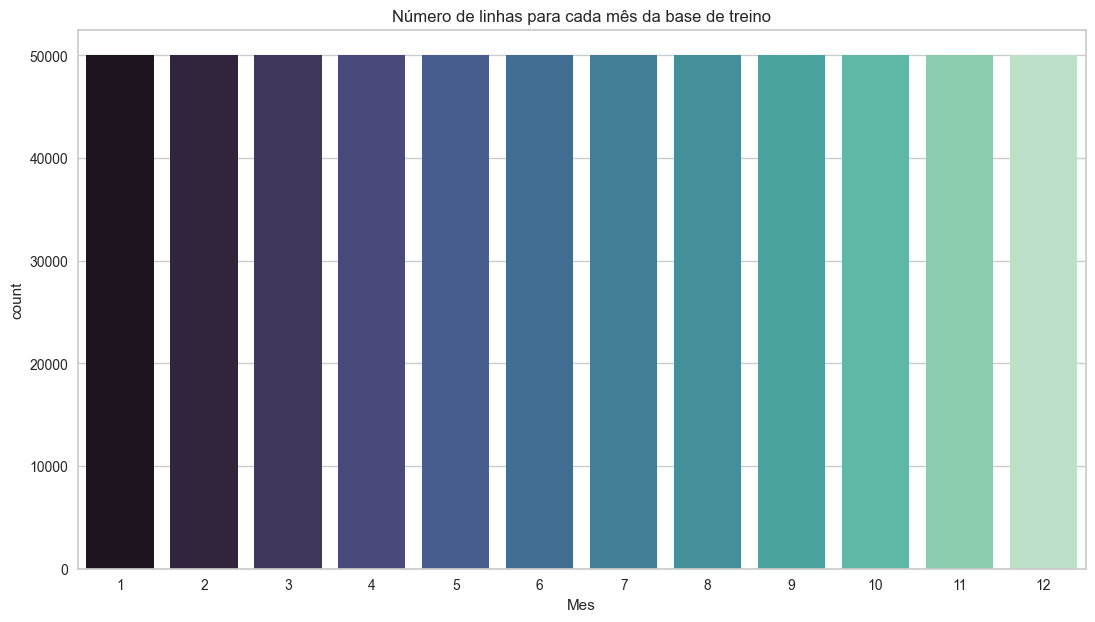

In [10]:
fig, ax = plt.subplots(figsize=(13,7))
sns.countplot(data=df_train, x='Mes', palette='mako', ax=ax)
ax.set_title('Número de linhas para cada mês da base de treino')

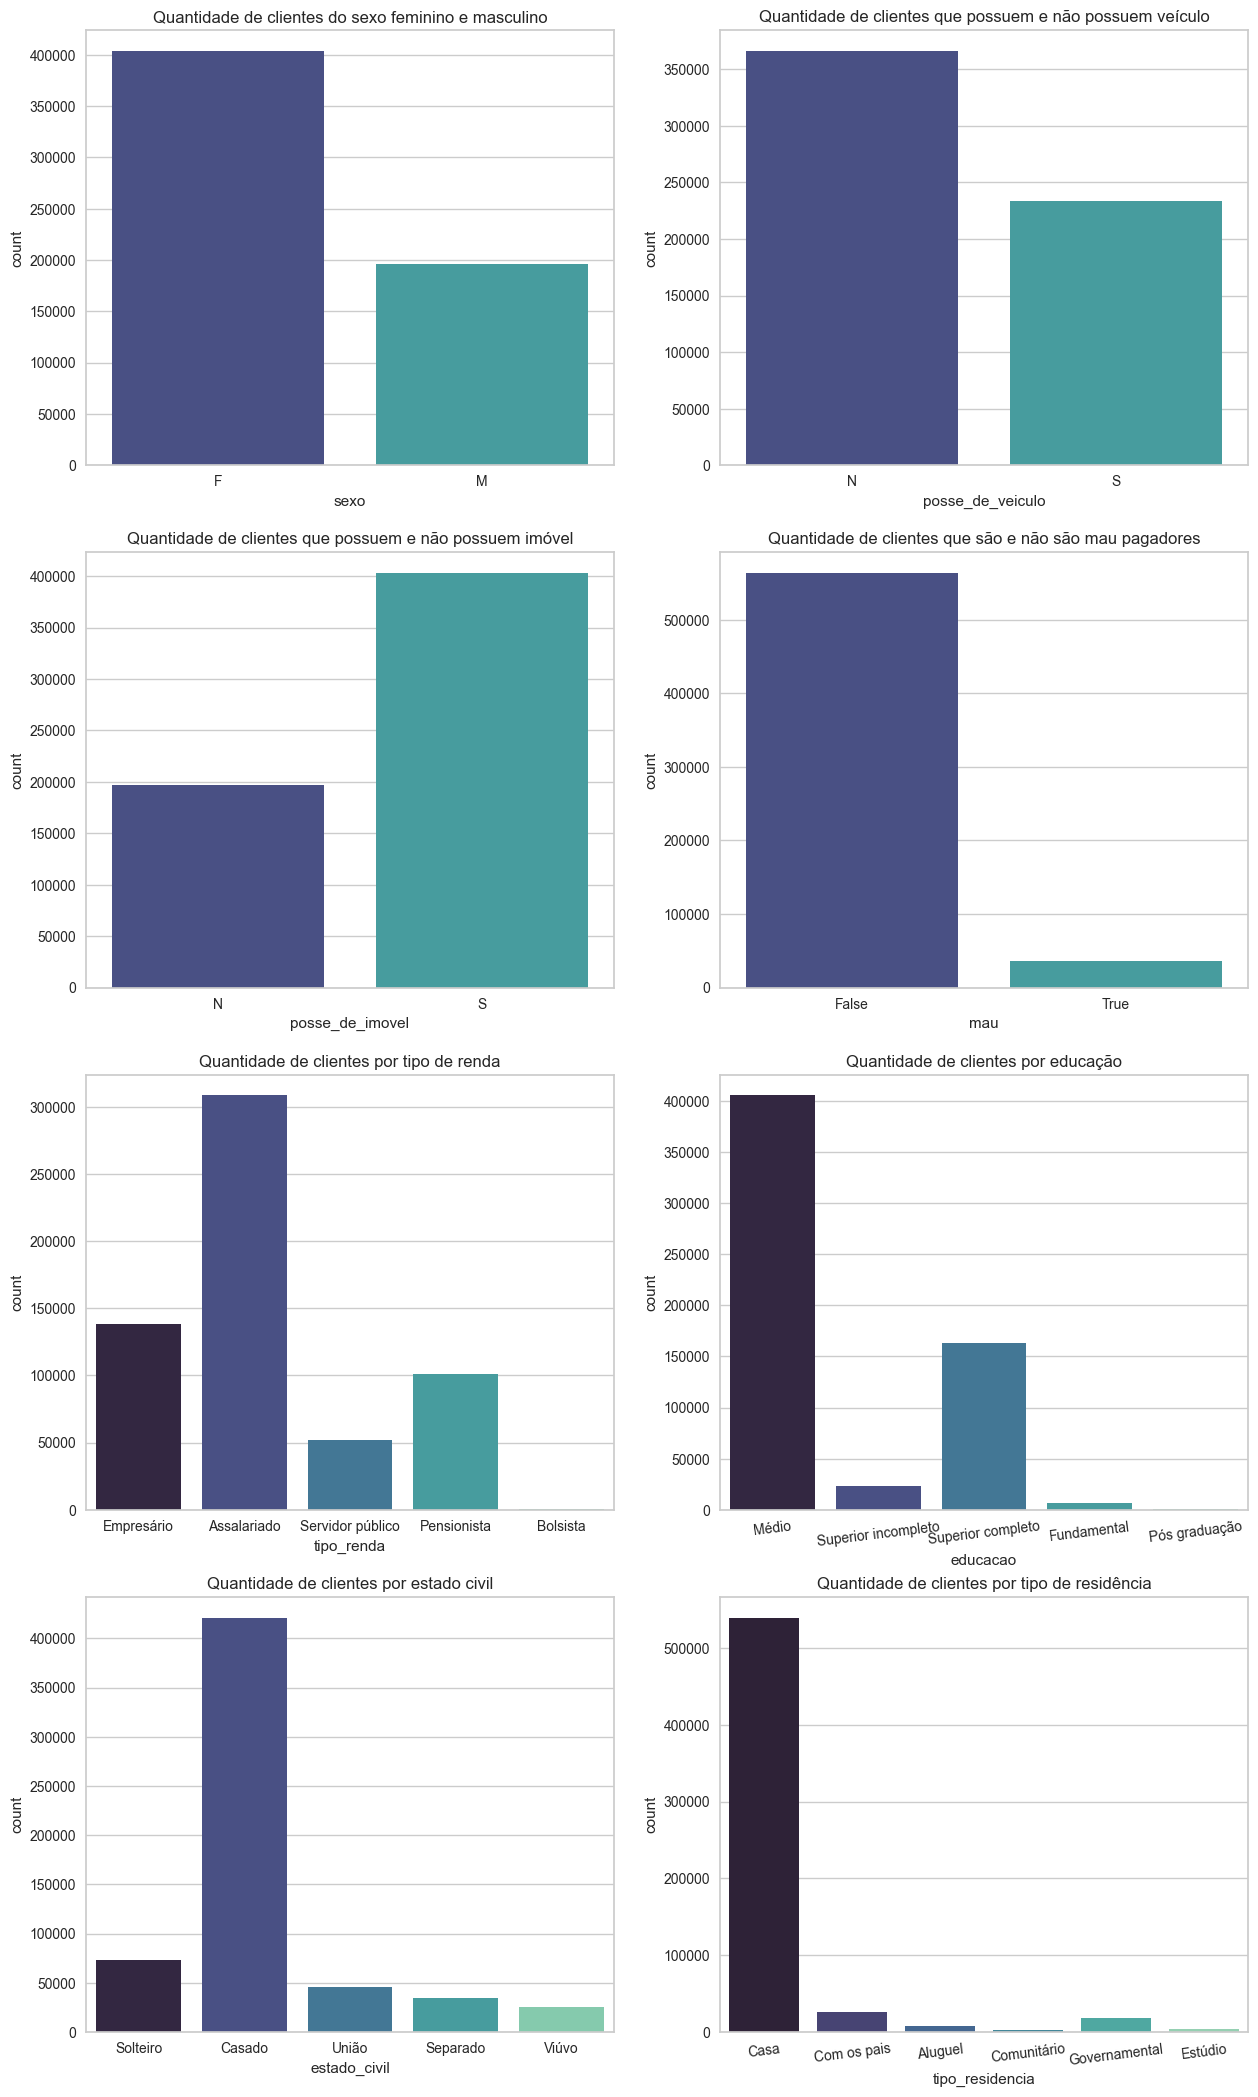

In [11]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,26))

sns.countplot(data=df_train, x='sexo', palette='mako', ax=ax[0,0])
ax[0,0].set_title('Quantidade de clientes do sexo feminino e masculino')

sns.countplot(data=df_train, x='posse_de_veiculo', palette='mako', ax=ax[0,1])
ax[0,1].set_title('Quantidade de clientes que possuem e não possuem veículo')

sns.countplot(data=df_train, x='posse_de_imovel', palette='mako', ax=ax[1,0])
ax[1,0].set_title('Quantidade de clientes que possuem e não possuem imóvel')

sns.countplot(data=df_train, x='mau', palette='mako', ax=ax[1,1])
ax[1,1].set_title('Quantidade de clientes que são e não são mau pagadores')

sns.countplot(data=df_train, x='tipo_renda', palette='mako', ax=ax[2,0])
ax[2,0].set_title('Quantidade de clientes por tipo de renda')

sns.countplot(data=df_train, x='educacao', palette='mako', ax=ax[2,1])
ax[2,1].set_title('Quantidade de clientes por educação')
for tick in ax[2,1].get_xticklabels():
    tick.set_rotation(7)

sns.countplot(data=df_train, x='estado_civil', palette='mako', ax=ax[3,0])
ax[3,0].set_title('Quantidade de clientes por estado civil')

sns.countplot(data=df_train, x='tipo_residencia', palette='mako', ax=ax[3,1])
ax[3,1].set_title('Quantidade de clientes por tipo de residência')
for tick in ax[3,1].get_xticklabels():
    tick.set_rotation(7)

Text(0.5, 1.0, 'Quantidade de clientes por renda')

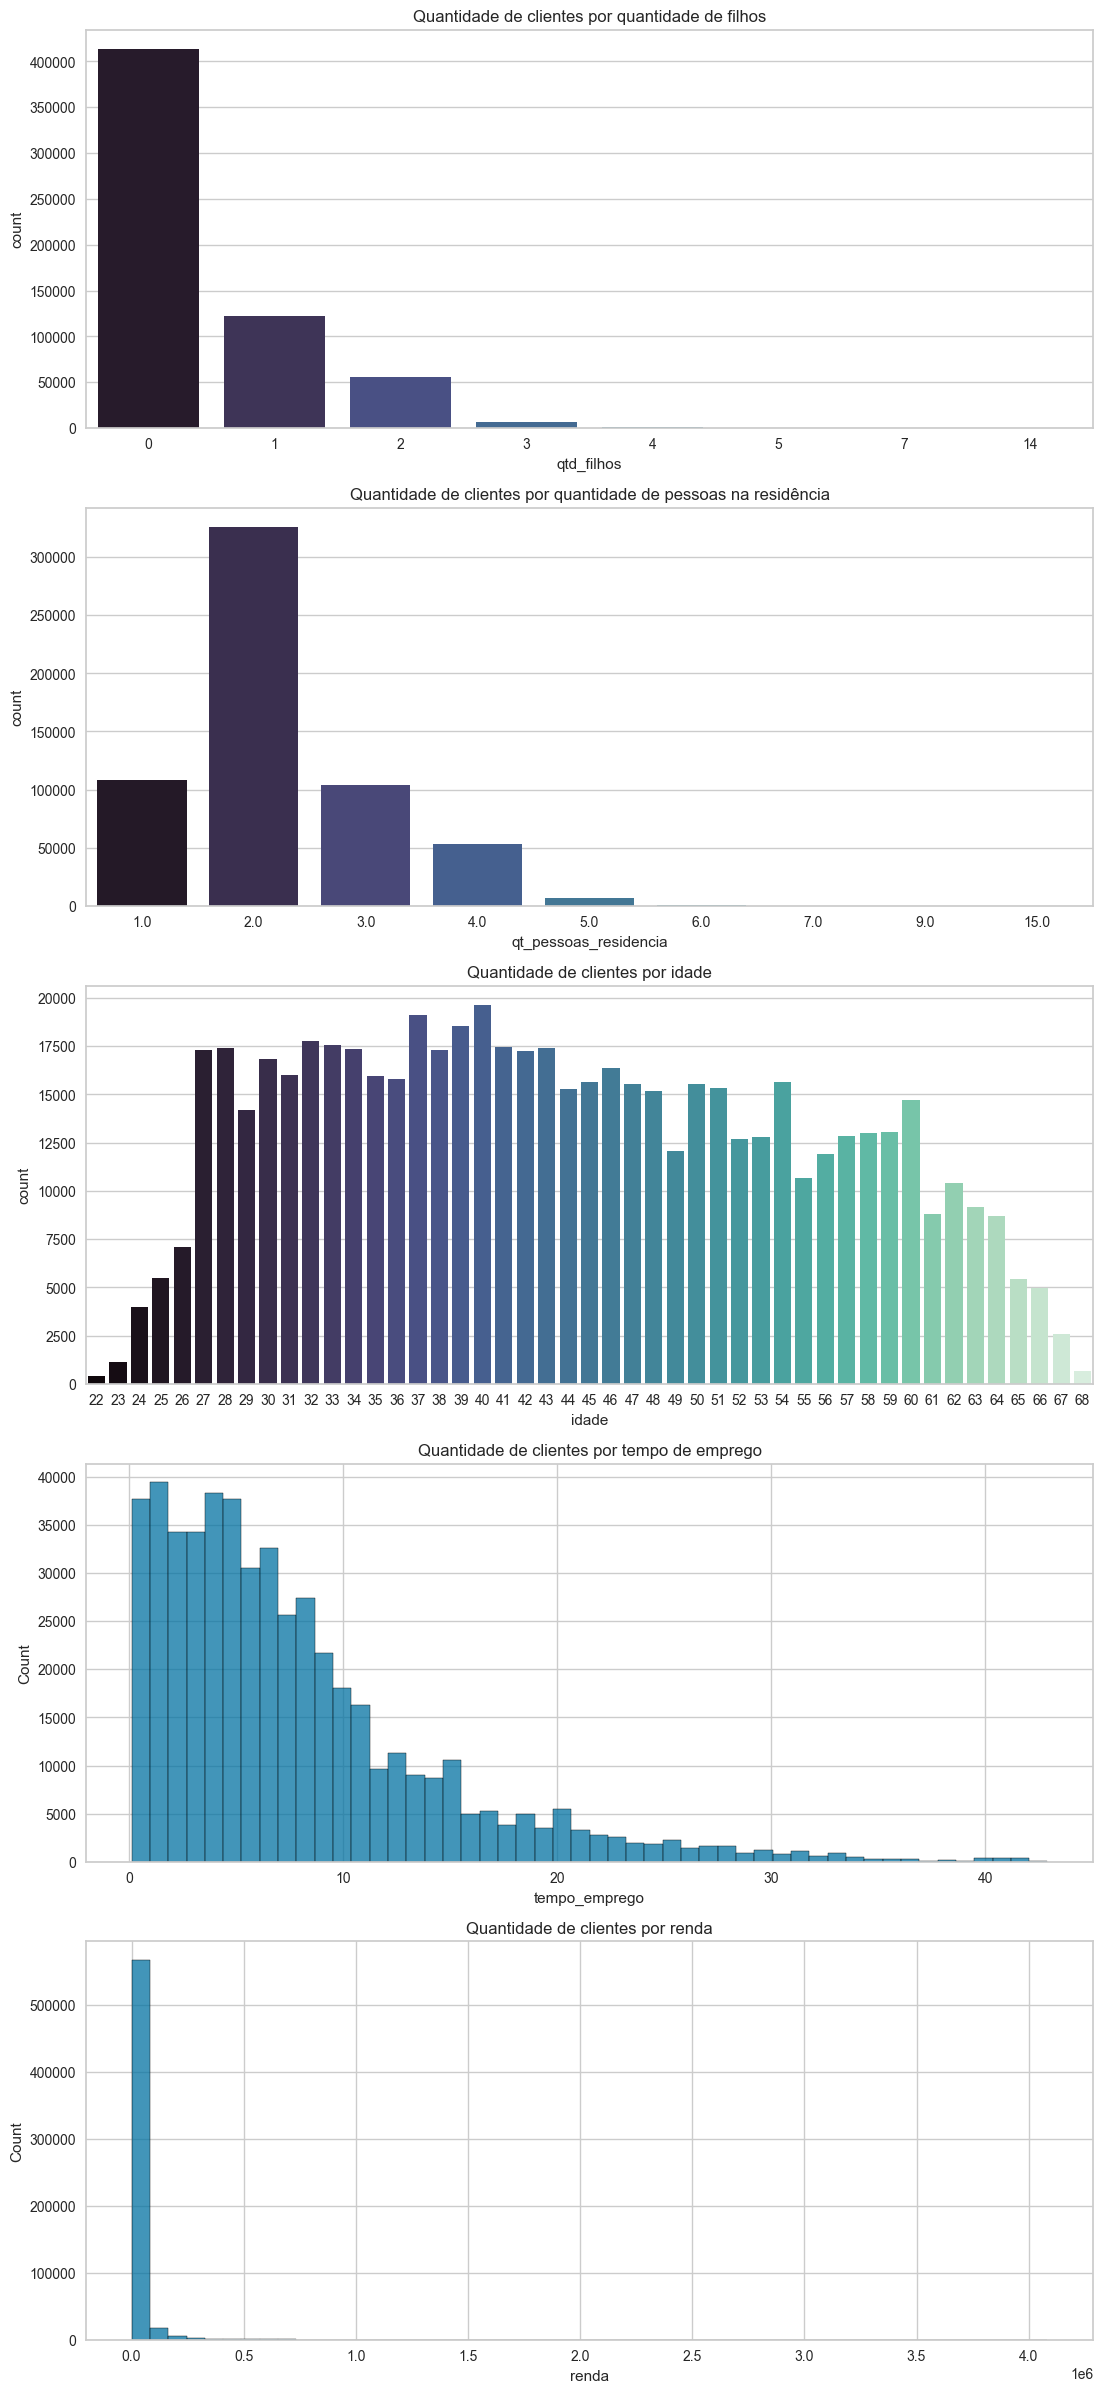

In [12]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(13,30))

sns.countplot(data=df_train, x='qtd_filhos', palette='mako', ax=ax[0])
ax[0].set_title('Quantidade de clientes por quantidade de filhos')

sns.countplot(data=df_train, x='qt_pessoas_residencia', palette='mako', ax=ax[1])
ax[1].set_title('Quantidade de clientes por quantidade de pessoas na residência')

sns.countplot(data=df_train, x='idade', palette='mako', ax=ax[2])
ax[2].set_title('Quantidade de clientes por idade')

sns.histplot(data=df_train, x='tempo_emprego', palette='dark', bins=50, ax=ax[3])
ax[3].set_title('Quantidade de clientes por tempo de emprego')

sns.histplot(data=df_train, x='renda', palette='dark', bins=50, ax=ax[4])
ax[4].set_title('Quantidade de clientes por renda')

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

Text(0, 0.5, 'Proporção de inadimplentes')

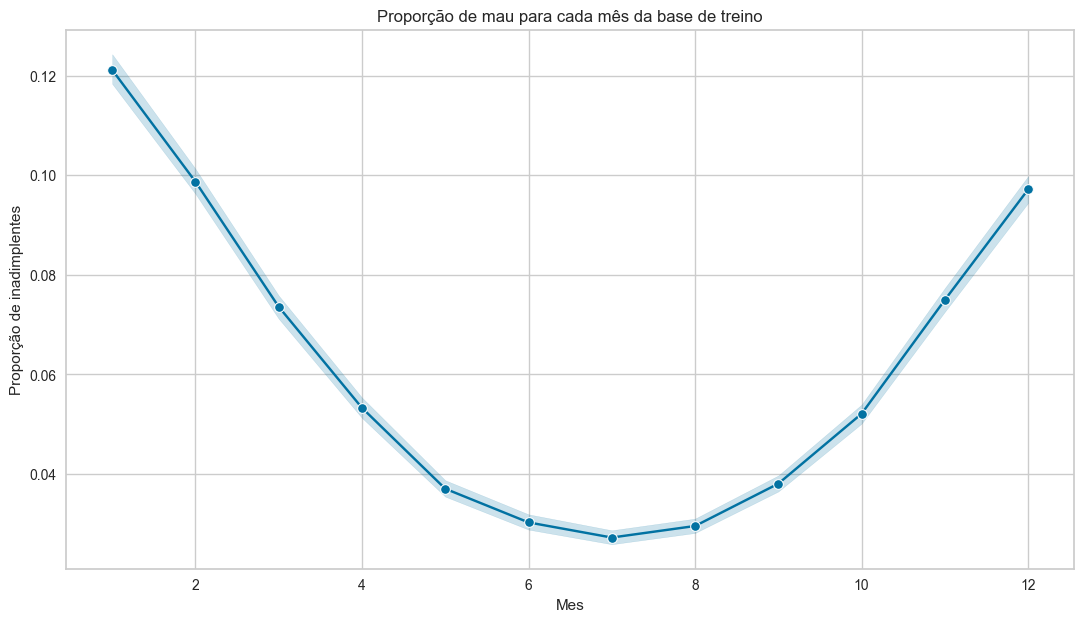

In [13]:
fig, ax = plt.subplots(figsize=(13,7))
sns.lineplot(data=df_train, x='Mes', y='mau', palette='mako', ax=ax, marker='o')
ax.set_title('Proporção de mau para cada mês da base de treino')
ax.set_ylabel("Proporção de inadimplentes")

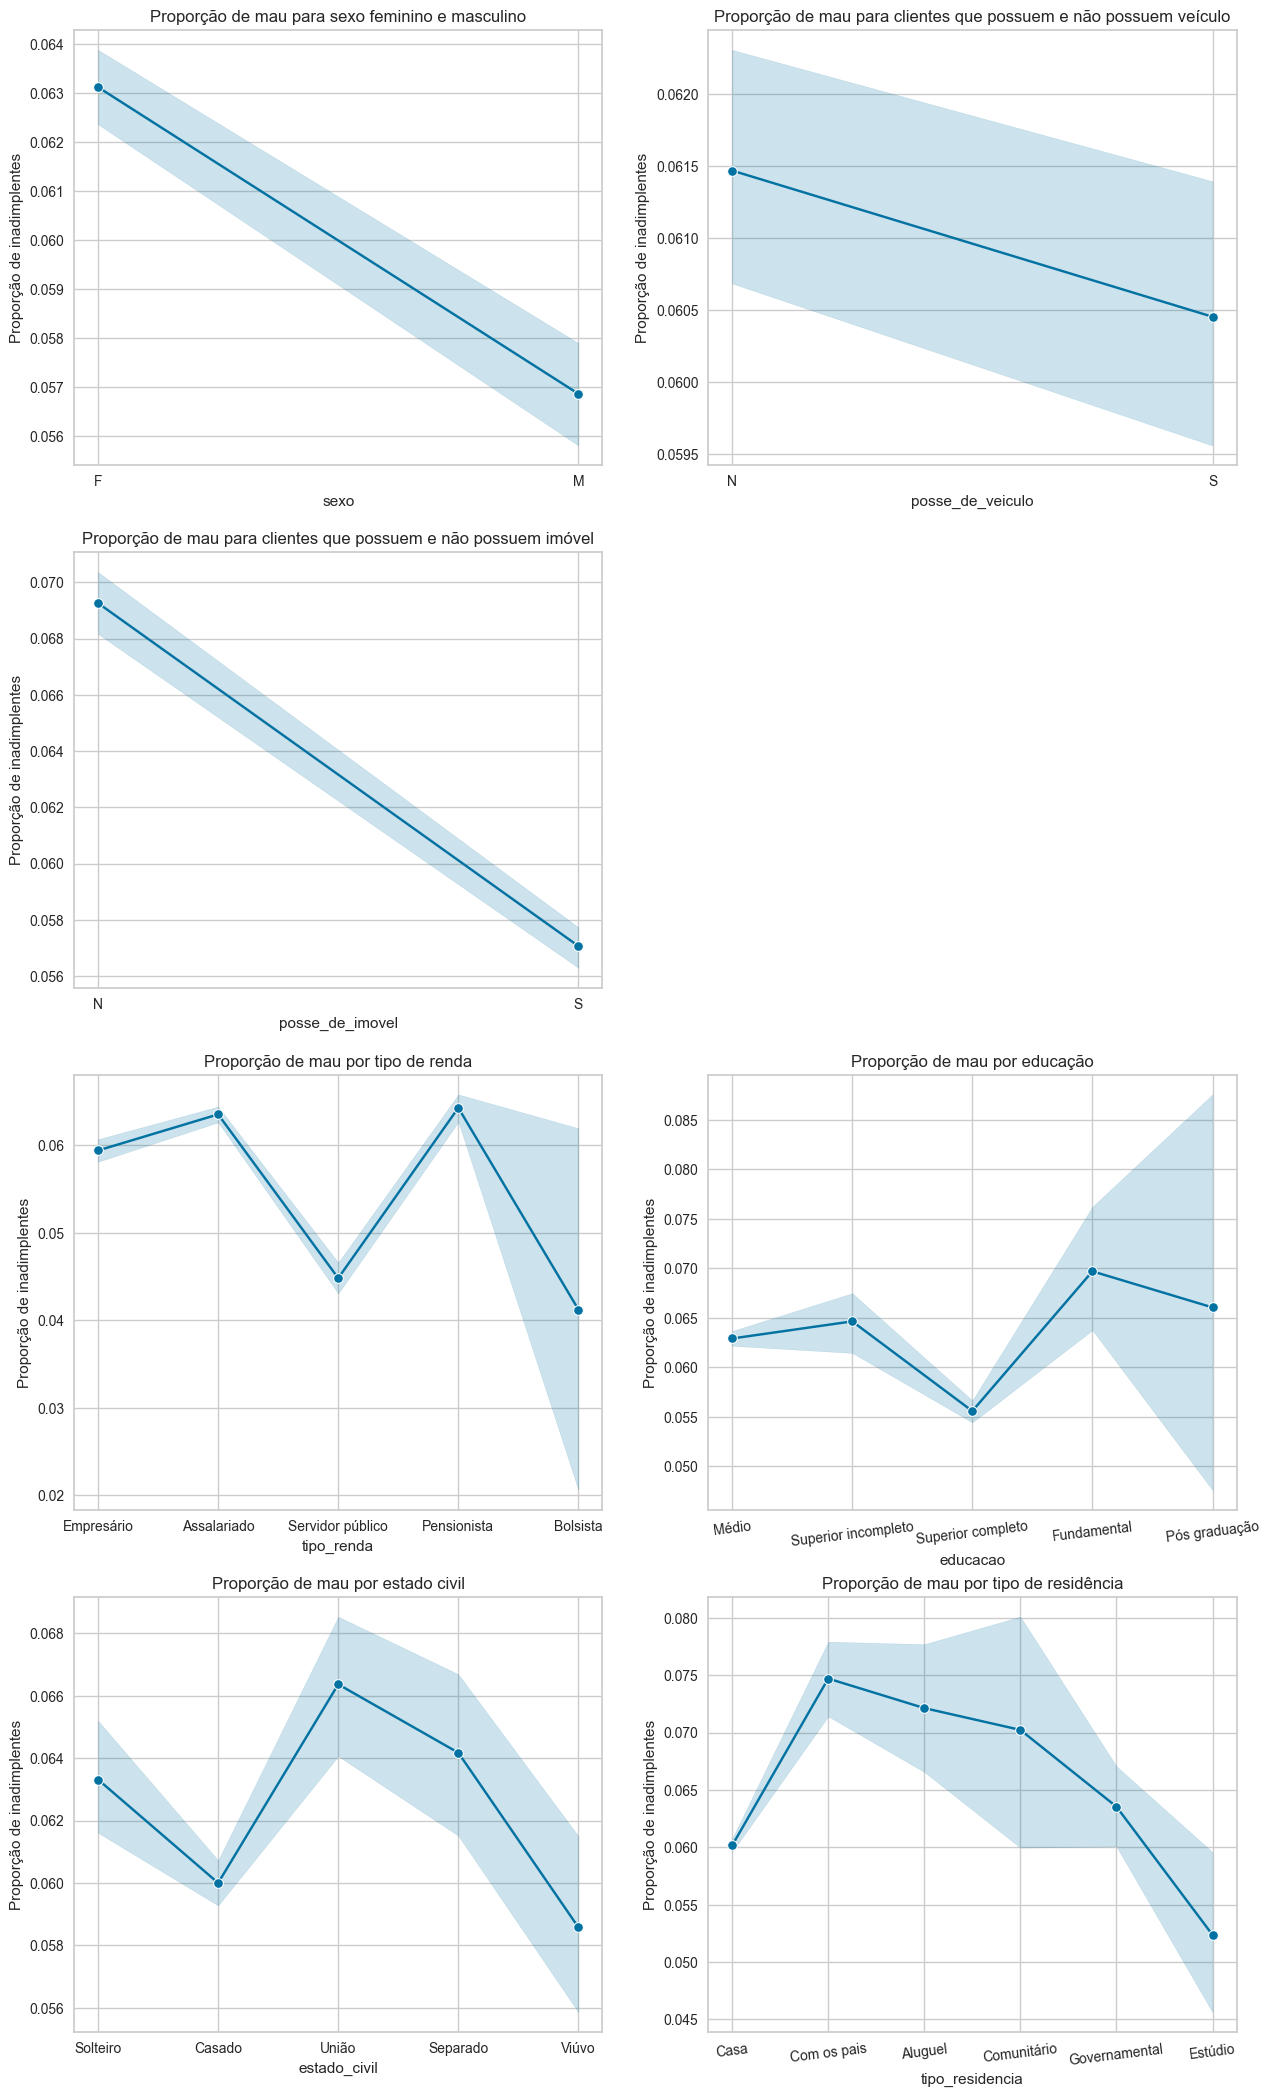

In [14]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,26))

sns.lineplot(data=df_train, x='sexo', y='mau', palette='mako', ax=ax[0,0], marker='o')
ax[0,0].set_title('Proporção de mau para sexo feminino e masculino')
ax[0,0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='posse_de_veiculo', y='mau', palette='mako', ax=ax[0,1], marker='o')
ax[0,1].set_title('Proporção de mau para clientes que possuem e não possuem veículo')
ax[0,1].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='posse_de_imovel', y='mau', palette='mako', ax=ax[1,0], marker='o')
ax[1,0].set_title('Proporção de mau para clientes que possuem e não possuem imóvel')
ax[1,0].set_ylabel("Proporção de inadimplentes")

ax[1,1].axis('off')

sns.lineplot(data=df_train, x='tipo_renda', y='mau', palette='mako', ax=ax[2,0], marker='o')
ax[2,0].set_title('Proporção de mau por tipo de renda')
ax[2,0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='educacao', y='mau', palette='mako', ax=ax[2,1], marker='o')
ax[2,1].set_title('Proporção de mau por educação')
ax[2,1].set_ylabel("Proporção de inadimplentes")
for tick in ax[2,1].get_xticklabels():
    tick.set_rotation(7)

sns.lineplot(data=df_train, x='estado_civil', y='mau', palette='mako', ax=ax[3,0], marker='o')
ax[3,0].set_title('Proporção de mau por estado civil')
ax[3,0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='tipo_residencia', y='mau', palette='mako', ax=ax[3,1], marker='o')
ax[3,1].set_title('Proporção de mau por tipo de residência')
ax[3,1].set_ylabel("Proporção de inadimplentes")
for tick in ax[3,1].get_xticklabels():
    tick.set_rotation(7)

Text(0, 0.5, 'Proporção de inadimplentes')

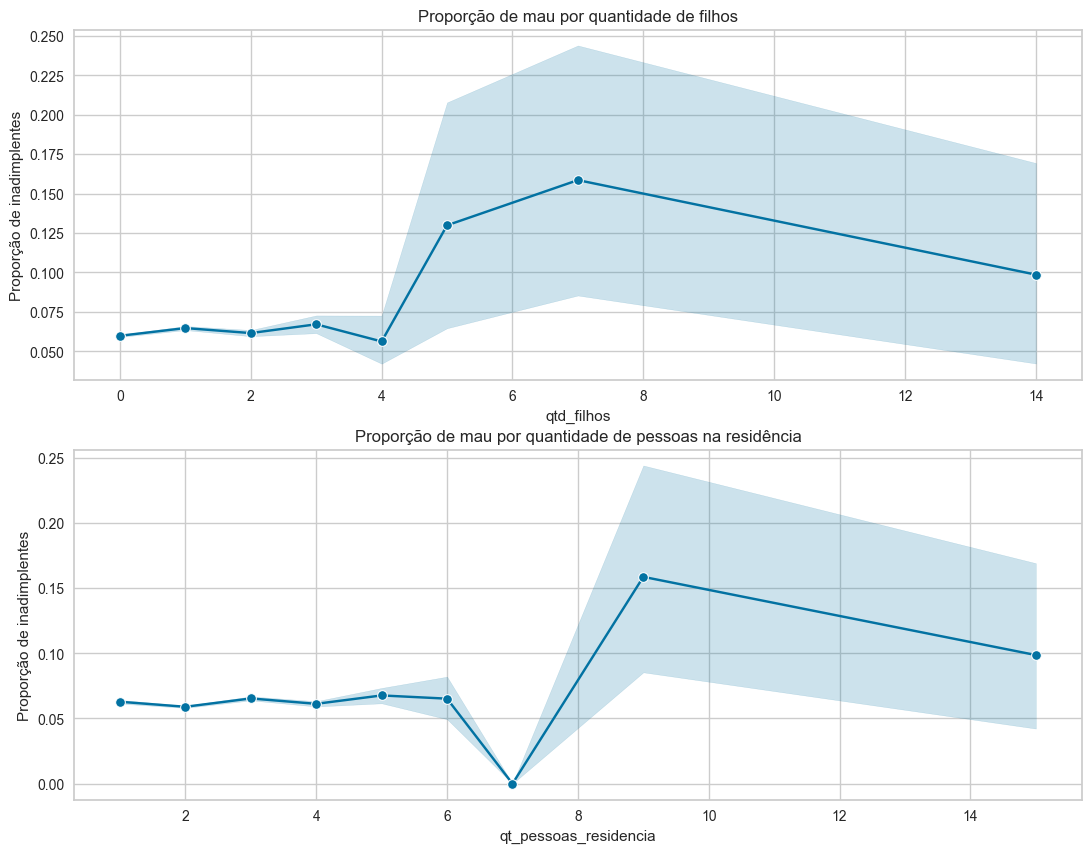

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13,10))

sns.lineplot(data=df_train, x='qtd_filhos', y='mau', palette='mako', ax=ax[0], marker='o')
ax[0].set_title('Proporção de mau por quantidade de filhos')
ax[0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='qt_pessoas_residencia', y='mau', palette='mako', ax=ax[1], marker='o')
ax[1].set_title('Proporção de mau por quantidade de pessoas na residência')
ax[1].set_ylabel("Proporção de inadimplentes")

Text(0.5, 1.0, 'Proporção de mau para intervalos de renda')

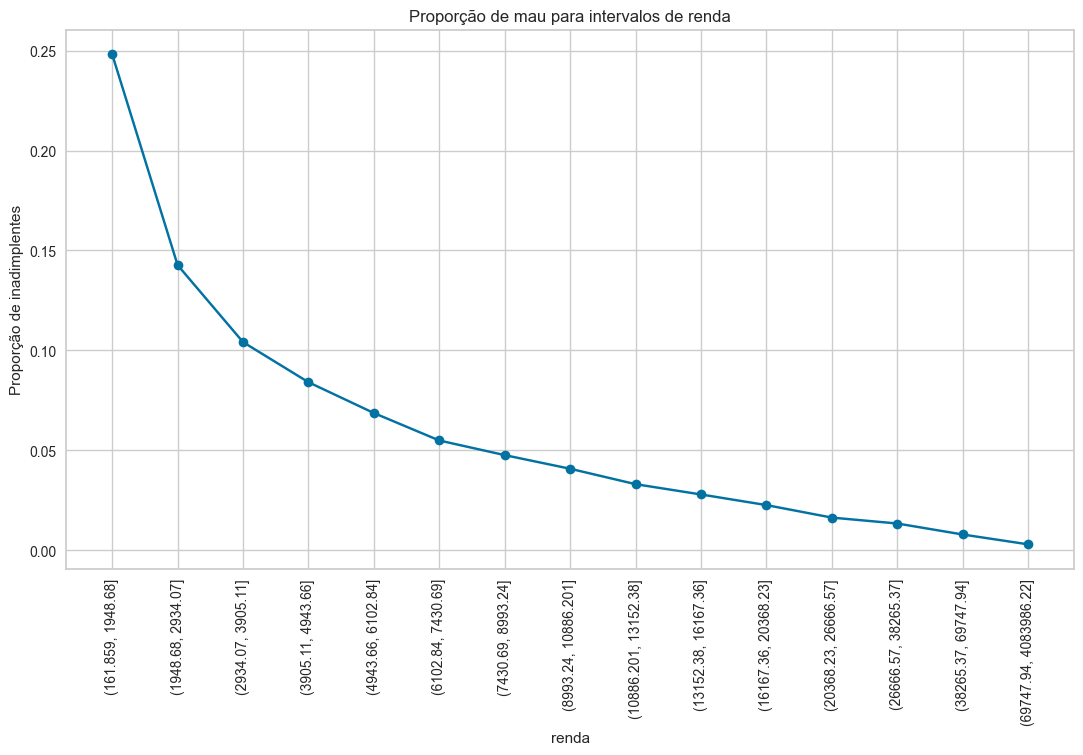

In [16]:
fig, ax = plt.subplots(figsize=(13,7))

cat_1, bins = pd.qcut(df_train['renda'], 15, retbins=True)
df_1 = df_train.groupby(cat_1)
biv = df_1['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation = 90)
ax.set_title('Proporção de mau para intervalos de renda')

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [17]:
df_train['mau'] = df_train.mau.astype('int64')
df_train.drop(columns = ['data_ref', 'index', 'Mes'], inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   600000 non-null  object 
 1   posse_de_veiculo       600000 non-null  object 
 2   posse_de_imovel        600000 non-null  object 
 3   qtd_filhos             600000 non-null  int64  
 4   tipo_renda             600000 non-null  object 
 5   educacao               600000 non-null  object 
 6   estado_civil           600000 non-null  object 
 7   tipo_residencia        600000 non-null  object 
 8   idade                  600000 non-null  int64  
 9   tempo_emprego          499125 non-null  float64
 10  qt_pessoas_residencia  600000 non-null  float64
 11  renda                  600000 non-null  float64
 12  mau                    600000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 59.5+ MB


In [18]:
df_train['tempo_emprego'].fillna(value=df_train['tempo_emprego'].mean(), inplace=True)

In [19]:
metadados = pd.DataFrame(df_train.dtypes, columns=['dtype'])
metadados['nmissing'] = df_train.isna().sum()
metadados['valores_unicos'] = df_train.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel
tempo_emprego,float64,0,3005,covariavel


In [20]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>10):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_train[var],5,duplicates='drop'), df_train.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df_train[var], df_train.mau)
    
metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0,2,covariavel,0.002665
posse_de_veiculo,object,0,2,covariavel,0.000075
posse_de_imovel,object,0,2,covariavel,0.009690
qtd_filhos,int64,0,8,covariavel,0.001689
tipo_renda,object,0,5,covariavel,0.009718
educacao,object,0,5,covariavel,0.003690
estado_civil,object,0,5,covariavel,0.001305
tipo_residencia,object,0,6,covariavel,0.003330
idade,int64,0,47,covariavel,0.018434
tempo_emprego,float64,0,3005,covariavel,0.283956


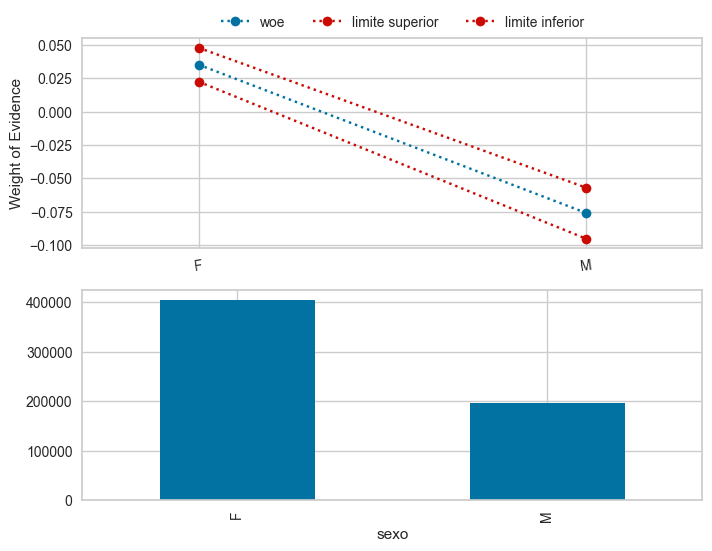

In [21]:
biv_discreta('sexo', df_train);

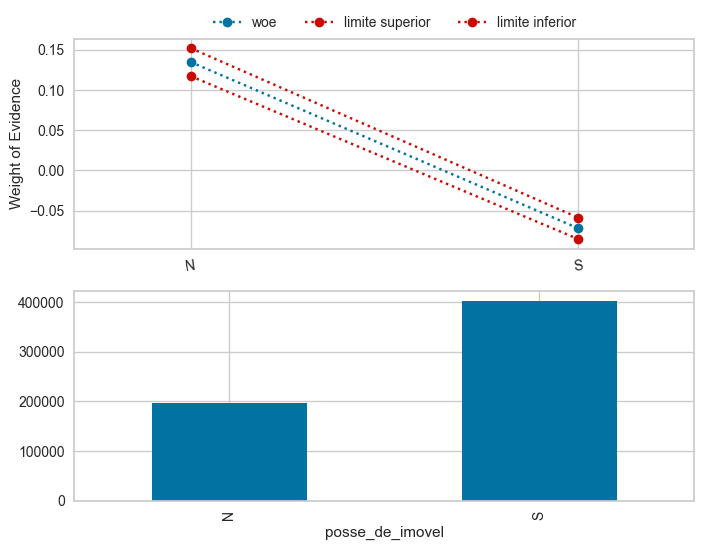

In [22]:
biv_discreta('posse_de_imovel', df_train);

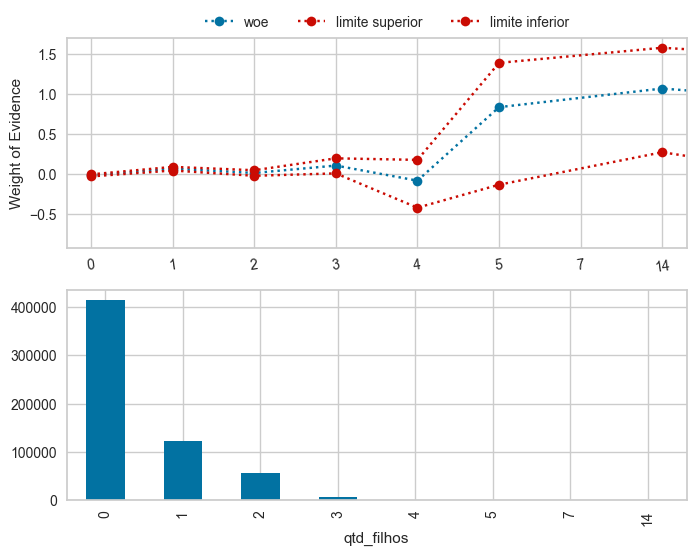

In [23]:
biv_discreta('qtd_filhos', df_train);

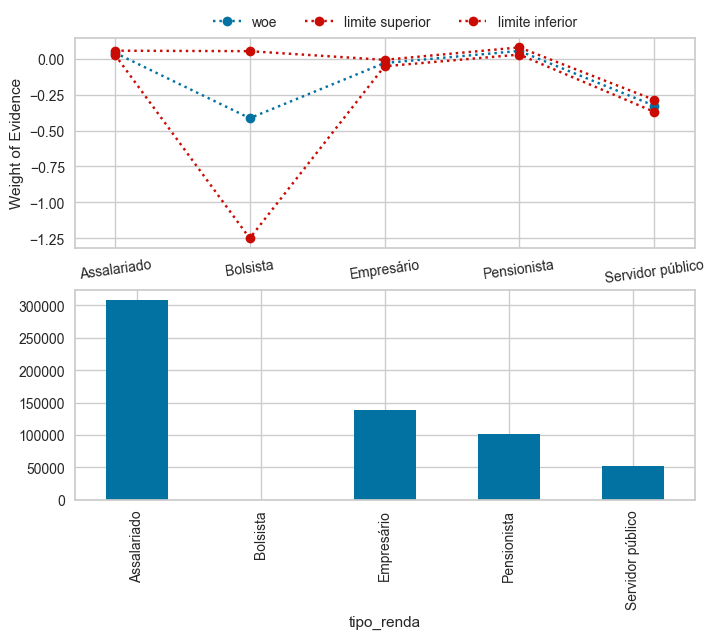

In [24]:
biv_discreta('tipo_renda', df_train);

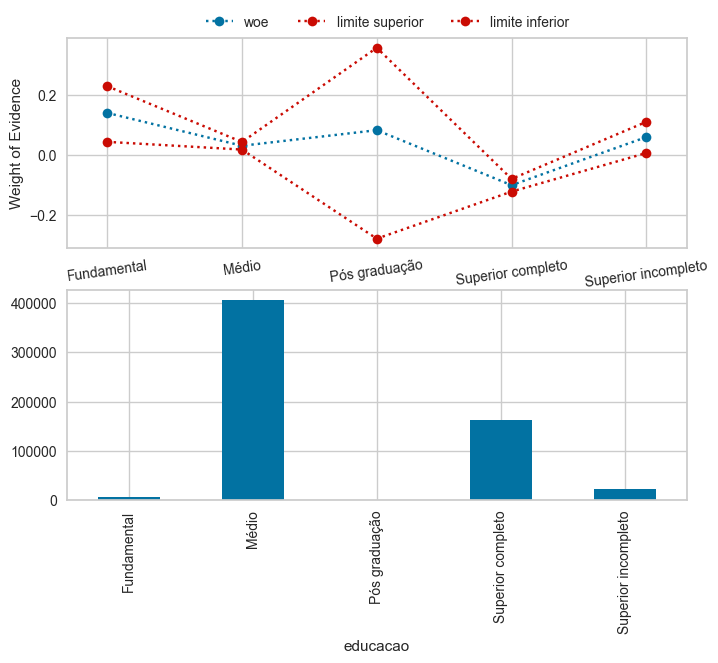

In [25]:
biv_discreta('educacao', df_train);

0.0034801108923340892

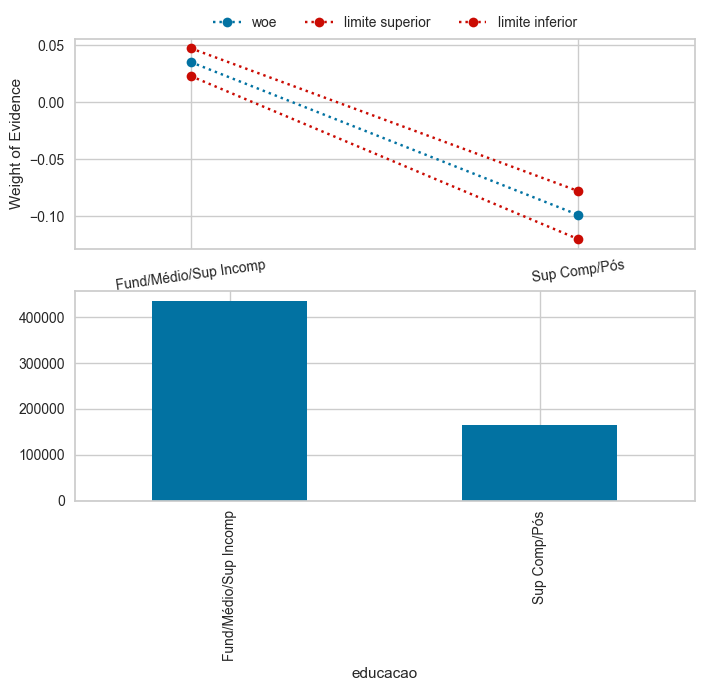

In [26]:
df_train.educacao.replace({'Fundamental':'Fund/Médio/Sup Incomp', 
                      'Médio':'Fund/Médio/Sup Incomp',
                      'Superior incompleto':'Fund/Médio/Sup Incomp',
                      'Superior completo': 'Sup Comp/Pós',
                      'Pós graduação': 'Sup Comp/Pós'
                     }, inplace=True)

biv_discreta('educacao', df_train);
IV(df_train.educacao, df_train.mau)

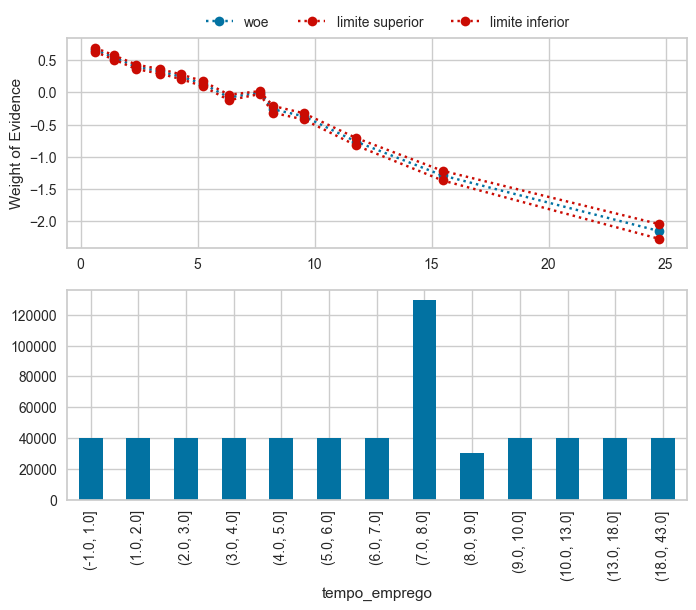

In [27]:
biv_continua('tempo_emprego', 15, df_train)

In [28]:
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + 
    educacao + estado_civil + tipo_residencia + idade + tempo_emprego +
    renda
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599978
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2488e+05
Date:                Fri, 11 Nov 2022   Deviance:                   2.4965e+05
Time:                        10:38:11   Pearson chi2:                 1.57e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04260
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.4187      0.053    -26.820      0.000      -1.522      -1.315
sexo[T.M]                           -0.1255      0.013     -9.564      0.000      -0.151      -0.100
posse_de_veiculo[T.S]                0.0314      0.012      2.535      0.011       0.007       0.056
posse_de_imovel[T.S]                -0.0848      0.012     -7.183      0.000      -0.108      -0.062
tipo_renda[T.Bolsista]               0.1216      0.300      0.405      0.685      -0.466       0.710
tipo_renda[T.Empresário]            -0.0545      0.014     -3.893      0.000      -0.082      -0.027
tipo_renda[T.Pensionista]           -0.0408      0.020     -2.018      0.044      -0.080      -0.001
tipo_renda[T.Servidor público]      -0.0329      0.023     -1.415      0.157      -0.078       0.013
educacao[T.Sup Comp/Pós]            -0.0568      0.013     -4.337      0.000      -0.082      -0.031
estado_civil[T.Separado]             0.0375      0.024      1.578      0.115      -0.009       0.084
estado_civil[T.Solteiro]             0.0055      0.017      0.315      0.753      -0.029       0.039
estado_civil[T.União]                0.0473      0.020      2.324      0.020       0.007       0.087
estado_civil[T.Viúvo]               -0.0345      0.029     -1.189      0.234      -0.091       0.022
tipo_residencia[T.Casa]             -0.0879      0.044     -1.995      0.046      -0.174      -0.002
tipo_residencia[T.Com os pais]      -0.0731      0.050     -1.475      0.140      -0.170       0.024
tipo_residencia[T.Comunitário]      -0.1402      0.089     -1.571      0.116      -0.315       0.035
tipo_residencia[T.Estúdio]          -0.0327      0.082     -0.397      0.692      -0.194       0.129
tipo_residencia[T.Governamental]    -0.0834      0.053     -1.565      0.118      -0.188       0.021
qtd_filhos                           0.0036      0.008      0.452      0.651      -0.012       0.019
idade                                0.0003      0.001      0.387      0.699      -0.001       0.002
tempo_emprego                       -0.0236      0.002    -13.106      0.000      -0.027      -0.020
renda                               -0.0001   1.09e-06    -93.689      0.000      -0.000   -9.96e-05
====================================================================================================
"""

In [29]:
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + renda
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2490e+05
Date:                Fri, 11 Nov 2022   Deviance:                   2.4969e+05
Time:                        10:38:31   Pearson chi2:                 1.59e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04253
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4931      0.014   -107.439      0.000      -1.520      -1.466
sexo[T.M]                   -0.1072      0.012     -8.926      0.000      -0.131      -0.084
posse_de_imovel[T.S]        -0.0897      0.011     -7.845      0.000      -0.112      -0.067
educacao[T.Sup Comp/Pós]    -0.0569      0.013     -4.477      0.000      -0.082      -0.032
tempo_emprego               -0.0245      0.002    -14.616      0.000      -0.028      -0.021
renda                       -0.0001   1.08e-06    -94.209      0.000      -0.000   -9.96e-05
============================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [30]:
df_train['score'] = rl.predict(df_train)

acc = metrics.accuracy_score(df_train.mau, df_train.score>.068)
fpr, tpr, thresholds = metrics.roc_curve(df_train.mau, df_train.score)
auc = metrics.auc(fpr, tpr)
gini = 2*auc -1
ks = ks_2samp(df_train.loc[df_train.mau == 1, 'score'], df_train.loc[df_train.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 59.4% 
AUC: 76.6% 
GINI: 53.2%
KS: 39.4%


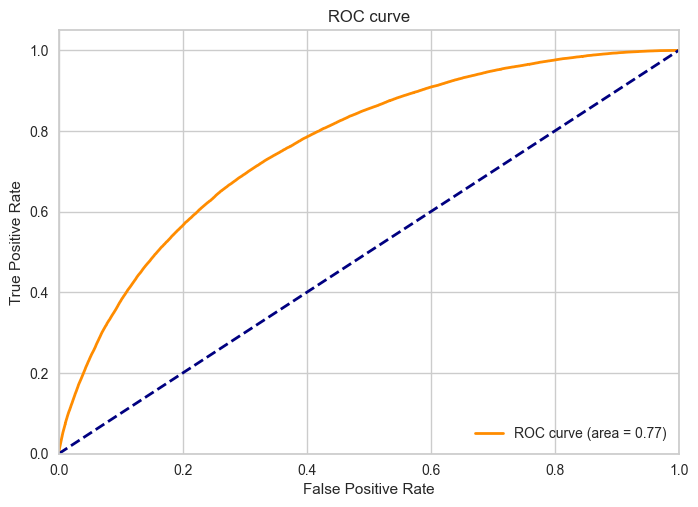

In [31]:
fpr, tpr, thresholds = metrics.roc_curve(df_train['mau'], df_train['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df_train['mau'], df_train['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'Função Distribuição Acumulada')

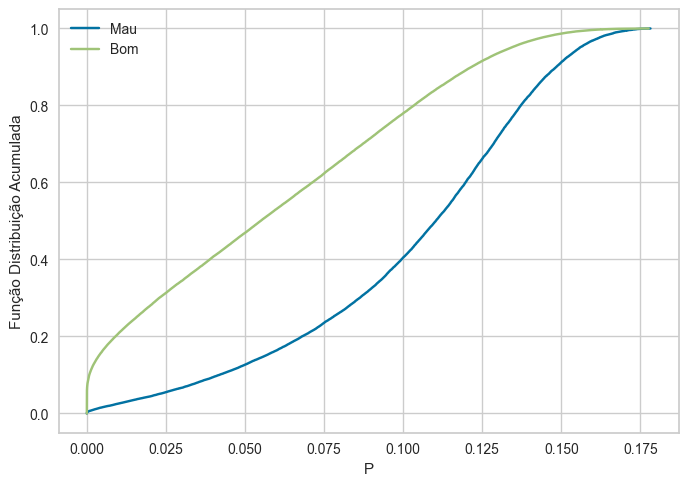

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df_train.loc[df_train['mau']==1,'score']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Mau')

score_pop2 = df_train.loc[df_train['mau']!=1,'score']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Bom')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [33]:
df.isna().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [34]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median()) 

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

<AxesSubplot: xlabel='tempo_emprego', ylabel='renda'>

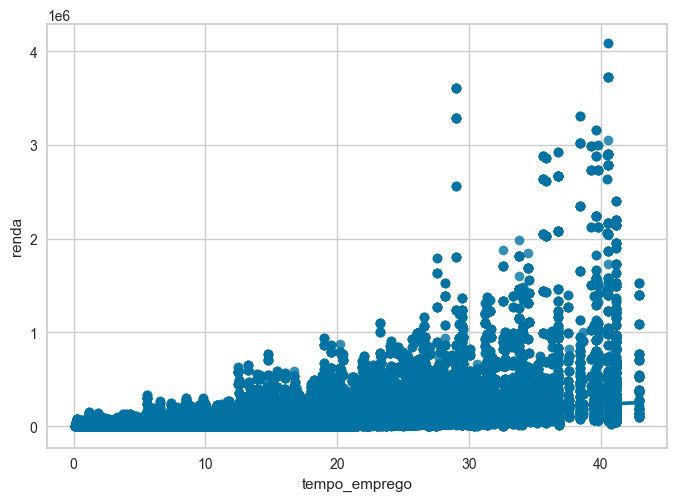

In [35]:
sns.regplot(y='renda', x='tempo_emprego', data=df)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [36]:
variaveis = ['renda', 'posse_de_imovel', 'idade', 'tempo_emprego',
       'qt_pessoas_residencia'] 


In [37]:
dataset = df.sample(400)

In [38]:
exp_aula4 = setup(data = dataset, target = 'mau', experiment_name='credit_1',
                  normalize=True, normalize_method='zscore', 
                  transformation=True, transformation_method = 'quantile',
                  fix_imbalance=True)


,Description,Value
0,session_id,4009
1,Target,mau
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(400, 14)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


In [39]:
best_model = compare_models(fold=4, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8997,0.7899,0.2250,0.2339,0.2269,0.1831,0.1841,0.0600
gbc,Gradient Boosting Classifier,0.9034,0.7757,0.2750,0.5208,0.3082,0.2628,0.3025,0.0850
rf,Random Forest Classifier,0.9033,0.7630,0.0833,0.1458,0.1056,0.0684,0.0710,0.1900
ada,Ada Boost Classifier,0.8746,0.7590,0.4083,0.3062,0.3357,0.2769,0.2838,0.0850
lr,Logistic Regression,0.7314,0.7281,0.4583,0.1307,0.2015,0.0928,0.1247,4.9425
et,Extra Trees Classifier,0.9176,0.7159,0.0500,0.1250,0.0714,0.0576,0.0621,0.1575
lda,Linear Discriminant Analysis,0.6885,0.6927,0.4583,0.1126,0.1796,0.0631,0.0924,0.0225
knn,K Neighbors Classifier,0.6633,0.6898,0.6417,0.1379,0.2264,0.1117,0.1694,0.0650
dt,Decision Tree Classifier,0.8496,0.5827,0.2667,0.1566,0.1876,0.1160,0.1244,0.0200
dummy,Dummy Classifier,0.9212,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0150


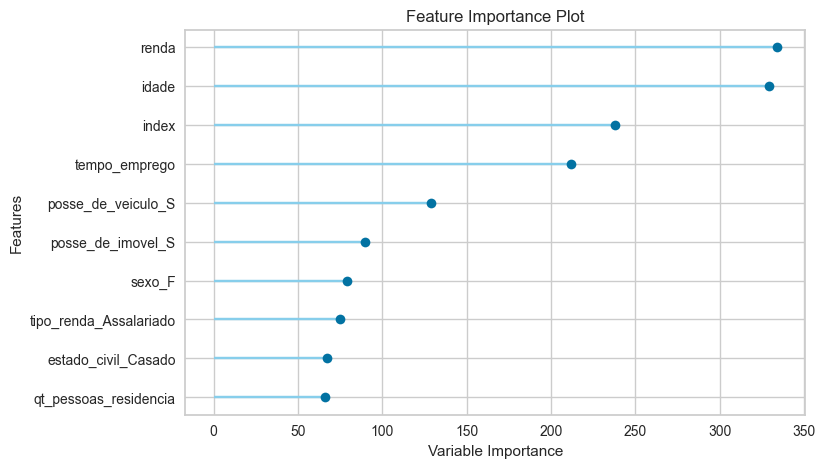

In [40]:
plot_model(best_model, plot='feature')

In [41]:
save_model(best_model,'LR Model Aula 5 062022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='mau',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
                                 min_child_samples=20,

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [42]:
X_digits, y_digits = load_digits(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.3, random_state=10)

In [43]:
pca_pipe = PCA(n_components=5)

In [44]:
pca.fit(X_train)
X_train = pca.transform(X_train)

NameError: name 'pca' is not defined

In [47]:
X_test = pca.transform(X_test)

NameError: name 'pca' is not defined

In [48]:
pipe = Pipeline(steps=[("pca", pca_pipe)])

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [45]:
df1 = pd.get_dummies(dataset, columns=['tipo_residencia'
                                                 ,'estado_civil'
                                                 ,'educacao'
                                                 ,'tipo_renda'
                                                 ,'posse_de_imovel'
                                                 ,'posse_de_veiculo'
                                                 ,'sexo']
                               , drop_first=True)
df1.head(20)

,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,...,educacao_Médio,educacao_Pós graduação,educacao_Superior completo,educacao_Superior incompleto,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_Servidor público,posse_de_imovel_S,posse_de_veiculo_S,sexo_M
data_ref,,,,,,,,,,,,,,,,,,,,,
2015-02-01,11574,1,46,3.991781,3.0,9806.53,False,0,0,0,...,1,0,0,0,0,0,0,1,1,1
2015-06-01,1315,0,47,9.589041,2.0,25861.31,False,1,0,0,...,1,0,0,0,0,0,1,1,1,1
2015-07-01,6963,0,59,6.046575,2.0,4342.12,False,0,0,0,...,1,0,0,0,0,1,0,1,0,0
2015-11-01,7475,0,59,2.736986,1.0,4229.76,False,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2015-07-01,6207,0,29,4.663014,1.0,41958.44,False,1,0,0,...,0,0,0,1,0,0,0,1,1,1
2015-02-01,16393,1,47,5.630137,2.0,11442.78,False,0,0,0,...,0,0,1,0,0,0,0,1,1,1
2016-01-01,5074,0,61,6.046575,2.0,5234.60,False,1,0,0,...,0,0,1,0,0,1,0,1,1,0
2015-11-01,3878,0,48,3.520548,2.0,7656.05,False,1,0,0,...,1,0,0,0,1,0,0,1,0,0
2015-10-01,13438,0,53,6.046575,2.0,4432.17,False,1,0,0,...,1,0,0,0,0,1,0,0,0,0


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [49]:
exp_aula4 = setup(data = dataset, remove_outliers=True, pca_method=True, fix_imbalance_method=True, target = 'posse_de_veiculo' )

ValueError: pca method parameter only accepts linear, kernel, incremental.

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [50]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (380, 14)
Conjunto de dados não usados no treino/teste, apenas como validação: (0, 14)


In [51]:
from pycaret.classification import *

In [52]:
best_model = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.9212,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0180
et,Extra Trees Classifier,0.9140,0.6689,0.0900,0.2000,0.1238,0.0973,0.1034,0.2740
lightgbm,Light Gradient Boosting Machine,0.9140,0.7729,0.3300,0.2667,0.2927,0.2638,0.2669,0.0740
rf,Random Forest Classifier,0.9104,0.7986,0.0900,0.2000,0.1238,0.0935,0.1012,0.2260
gbc,Gradient Boosting Classifier,0.8997,0.7609,0.2800,0.2871,0.2694,0.2266,0.2335,0.1140
ada,Ada Boost Classifier,0.8853,0.8069,0.4600,0.2917,0.3502,0.2906,0.3042,0.1040
dt,Decision Tree Classifier,0.8710,0.5731,0.2200,0.2400,0.2152,0.1514,0.1561,0.0220
lr,Logistic Regression,0.7457,0.7483,0.5000,0.1452,0.2226,0.1183,0.1581,0.0320
svm,SVM - Linear Kernel,0.7353,0.0000,0.4900,0.1593,0.2223,0.1207,0.1579,0.0180
ridge,Ridge Classifier,0.7098,0.0000,0.5900,0.1447,0.2309,0.1221,0.1759,0.0200


In [53]:
print(best_model)

DummyClassifier(constant=None, random_state=4009, strategy='prior')


In [54]:
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.6923,0.5000,0.2500,0.3333,0.2632,0.2831
1,0.8571,0.9231,1.0000,0.3333,0.5000,0.4400,0.5311
2,0.7500,0.4038,0.0000,0.0000,0.0000,-0.1136,-0.1293
3,0.8929,0.4808,0.0000,0.0000,0.0000,-0.0500,-0.0534
4,0.8214,0.9038,1.0000,0.2857,0.4444,0.3750,0.4804
5,0.9286,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.8929,0.7115,0.5000,0.3333,0.4000,0.3438,0.3523
7,0.8929,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8571,0.6267,0.3333,0.3333,0.3333,0.2533,0.2533


In [55]:
print(dt)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=4009, splitter='best')


In [56]:
knn = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7500,0.9231,1.0000,0.2222,0.3636,0.2794,0.4030
1,0.7500,0.7981,0.5000,0.1429,0.2222,0.1250,0.1601
2,0.6786,0.5962,0.5000,0.1111,0.1818,0.0735,0.1060
3,0.6786,0.5962,0.5000,0.1111,0.1818,0.0735,0.1060
4,0.4643,0.5000,0.5000,0.0667,0.1176,-0.0096,-0.0199
5,0.6786,0.6923,0.5000,0.1111,0.1818,0.0735,0.1060
6,0.7500,0.7500,0.5000,0.1429,0.2222,0.1250,0.1601
7,0.8571,0.7533,0.6667,0.4000,0.5000,0.4227,0.4415
8,0.6786,0.6267,0.3333,0.1250,0.1818,0.0308,0.0365


In [57]:
tuned_dt = tune_model(dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9286,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9286,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9286,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9286,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9286,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9286,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9286,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.8929,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8929,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


In [58]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8929,0.9615,0.0000,0.0000,0.0000,-0.0500,-0.0534
1,0.9643,0.9423,0.5000,1.0000,0.6667,0.6500,0.6939
2,0.8929,0.7788,0.0000,0.0000,0.0000,-0.0500,-0.0534
3,0.9286,0.8269,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8929,0.8462,0.0000,0.0000,0.0000,-0.0500,-0.0534
5,0.9286,0.5769,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9643,0.9231,0.5000,1.0000,0.6667,0.6500,0.6939
7,0.8929,0.7133,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8929,0.6200,0.0000,0.0000,0.0000,0.0000,0.0000


In [59]:
tuned_rf = tune_model(rf, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.9038,1.0000,0.3333,0.5000,0.4400,0.5311
1,0.8571,0.8942,0.5000,0.2500,0.3333,0.2632,0.2831
2,0.7500,0.8269,0.5000,0.1429,0.2222,0.1250,0.1601
3,0.8214,0.6538,0.5000,0.2000,0.2857,0.2045,0.2328
4,0.6429,0.9038,1.0000,0.1667,0.2857,0.1860,0.3203
5,0.7857,0.6635,0.5000,0.1667,0.2500,0.1600,0.1931
6,0.7857,0.9038,1.0000,0.2500,0.4000,0.3226,0.4385
7,0.8214,0.5933,0.3333,0.2500,0.2857,0.1860,0.1886
8,0.8214,0.7467,0.3333,0.2500,0.2857,0.1860,0.1886


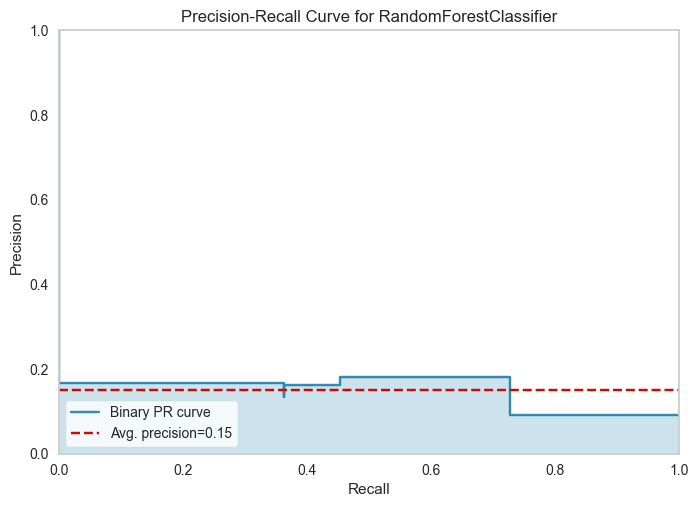

In [60]:
plot_model(tuned_rf, plot = 'pr')

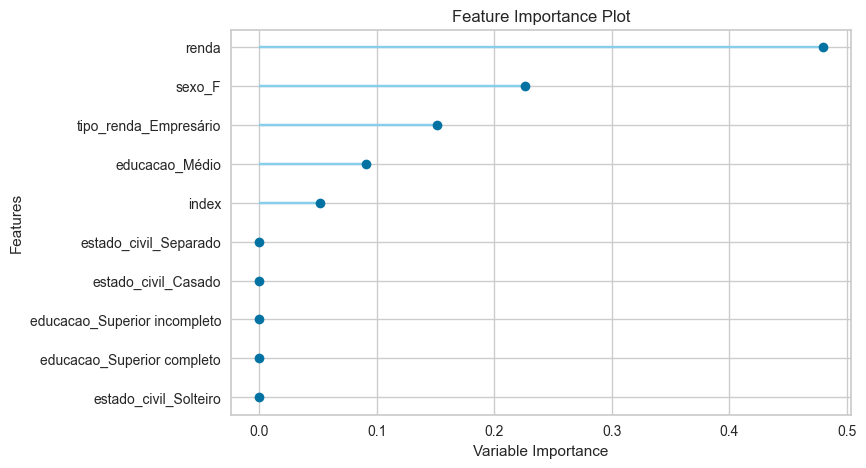

In [61]:
plot_model(tuned_rf, plot='feature')

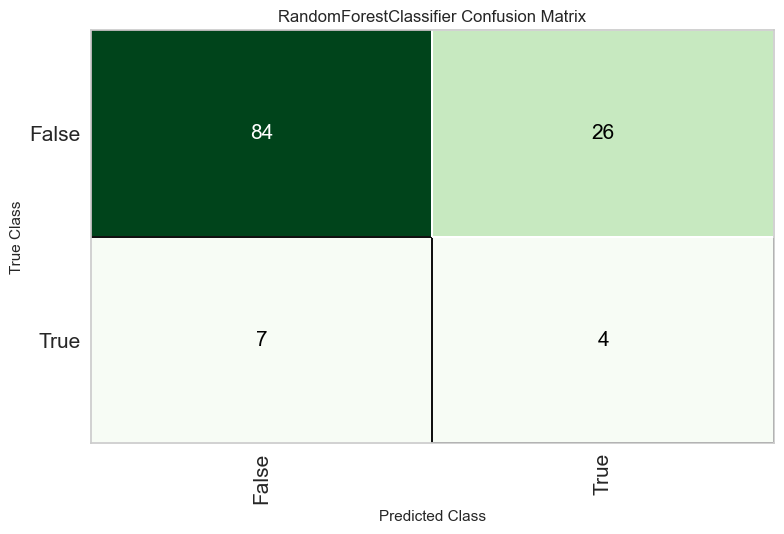

In [62]:
plot_model(tuned_rf, plot = 'confusion_matrix')

In [63]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [64]:
predict_model(tuned_rf);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7273,0.6851,0.3636,0.1333,0.1951,0.0716,0.0847


In [65]:
final_rf = finalize_model(tuned_rf)

In [66]:
formula = '''
    mau ~  + qtd_filhos + idade + tempo_emprego +  
    qt_pessoas_residencia
'''

rl = smf.glm(formula, data=df1, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:                  400
Model:                                     GLM   Df Residuals:                      395
Model Family:                         Binomial   Df Model:                            4
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -109.30
Date:                         Fri, 11 Nov 2022   Deviance:                       218.59
Time:                                 10:46:20   Pearson chi2:                     373.
No. Iterations:                              6   Pseudo R-squ. (CS):            0.02292
Covariance Type:                     nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.1111      1.178      1.791      0.073      -0.199       4.421
qtd_filhos                0.1763      0.567      0.311      0.756      -0.935       1.288
idade                    -0.0054      0.018     -0.304      0.761      -0.040       0.030
tempo_emprego             0.1370      0.054      2.555      0.011       0.032       0.242
qt_pessoas_residencia    -0.1475      0.477     -0.309      0.757      -1.082       0.787
=========================================================================================
"""

In [67]:
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
qt_pessoas_residencia,float64,0,9,covariavel,inf
renda,float64,0,112472,covariavel,0.959826
tempo_emprego,float64,0,3005,covariavel,0.283956
idade,int64,0,47,covariavel,0.018434
tipo_renda,object,0,5,covariavel,0.009718
posse_de_imovel,object,0,2,covariavel,0.009690
educacao,object,0,5,covariavel,0.003690
tipo_residencia,object,0,6,covariavel,0.003330
sexo,object,0,2,covariavel,0.002665
qtd_filhos,int64,0,8,covariavel,0.001689


In [68]:
import pickle

nome_arquivo = 'model_final.pkl'
pickle.dump(tuned_rf, open(nome_arquivo, 'wb'))

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.